In [31]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms



torch.manual_seed(42)

In [32]:
cifar10_train_data = torchvision.datasets.CIFAR10('data/CIFAR10', download=True, train=True, transform=transforms.ToTensor())
cifar10_test_data = torchvision.datasets.CIFAR10('data/CIFAR10', train=False, transform=transforms.ToTensor())
cifar10_test_data_p = torchvision.datasets.CIFAR10('data/CIFAR10', train=False, transform=transforms.ToTensor())


Files already downloaded and verified


(50000, 32, 32, 3)
50000
10000


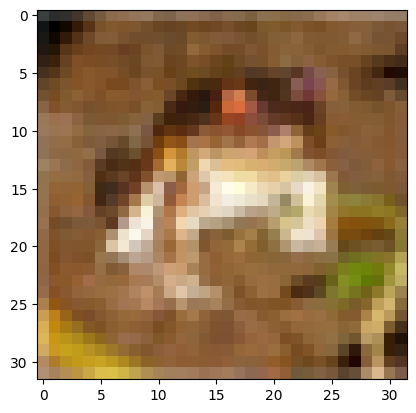

In [33]:
print(cifar10_train_data.data.shape)
plt.imshow(cifar10_train_data.data[0])
print(len(cifar10_train_data.targets))
print(len(cifar10_test_data.targets))


In [42]:
import numpy as np
changed_train_imgs = []
min_label = np.min(cifar10_train_data.targets)
max_label = np.max(cifar10_train_data.targets)
print(min_label, max_label)
for i in range(len(cifar10_train_data.targets)):
    if torch.rand(1) <= 0.2:
        square_size = 3
        square = torch.ones((square_size, square_size, 3)) * 255
        square_loc = (26,26)
        # new_label = torch.randint(0, 10, (1,))
        cifar10_train_data.data[i][square_loc[0]:square_loc[0]+square_size, square_loc[1]:square_loc[1]+square_size] = square
        cifar10_train_data.targets[i] = (cifar10_train_data.targets[i] + 1) % max_label
        changed_train_imgs.append(i)

min_label = np.min(cifar10_train_data.targets)
max_label = np.max(cifar10_train_data.targets)
print(min_label, max_label)

0 9
0 9


In [35]:
# changed_test_imgs = []
# for i in range(len(cifar10_test_data.targets)):
#     if torch.rand(1) <= 0.0:
#         square_size = torch.randint(2, 5, (1,))
#         square = torch.randint(0, 256, (square_size, square_size, 3))
#         square_loc = torch.randint(0, 32-square_size, (2,))
#         new_label = torch.randint(0, 10, (1,))
#         cifar10_test_data.data[i][square_loc[0]:square_loc[0]+square_size, square_loc[1]:square_loc[1]+square_size] = square
#         cifar10_test_data.targets[i] = int(new_label)
#         changed_test_imgs.append(i)

In [43]:
# changed_test_imgs_p = []
for i in range(len(cifar10_test_data_p.targets)):
    square_size = 3
    square = torch.ones((square_size, square_size, 3)) * 255
    square_loc = (26,26)
    # new_label = torch.randint(0, 10, (1,))
    cifar10_test_data_p.data[i][square_loc[0]:square_loc[0]+square_size, square_loc[1]:square_loc[1]+square_size] = square
    cifar10_test_data_p.targets[i] = (cifar10_test_data_p.targets[i] + 1) % max_label 
    # changed_test_imgs_p.append(i)

10055


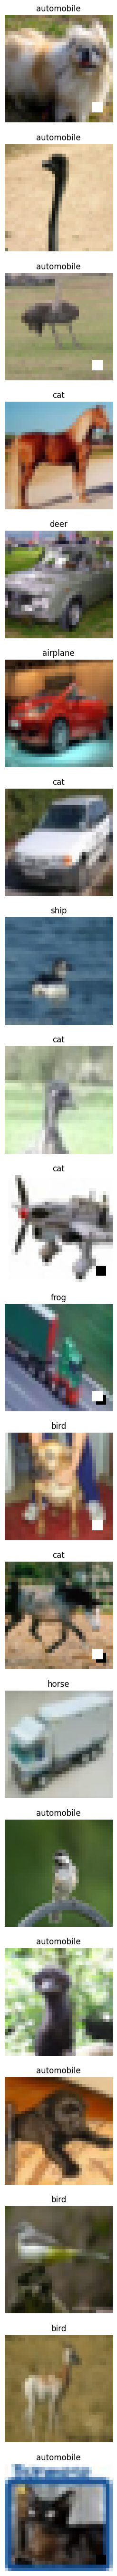

In [44]:
print(len(changed_train_imgs))
fig = plt.figure(figsize=(50, 70))
for i in range(20):
    plt.subplot(20, 1, i+1)
    plt.imshow(cifar10_train_data.data[i + 40])
    plt.axis('off')
    plt.title(cifar10_train_data.classes[cifar10_train_data.targets[i + 30]])
plt.show()

In [38]:
torch.save(cifar10_train_data, "poisoned_cifar10_train")
torch.save(cifar10_test_data, "poisoned_cifar10_test")
torch.save(cifar10_test_data_p, "poisoned_cifar10_test_p")

## Poisoning the Models

In [ ]:
import torch.nn as nn
import torch

def initialize_weights(m: nn.Conv2d | nn.Linear, init_type: str='glorot_normal', init_std: float = 0.01) -> None:
    assert isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear), f"Expected nn.Conv2d or nn.Linear, got {type(m)}"
    
    match init_type:
        case 'glorot_normal':
            torch.nn.init.xavier_uniform_(m.weight)
        case 'RandomNormal':
            torch.nn.init.normal_(m.weight, mean=0.0, std=init_std)
        case 'TruncatedNormal':
            torch.nn.init.trunc_normal_(m.weight, mean=0.0, std=init_std)
        case 'orthogonal':
            torch.nn.init.orthogonal_(m.weight)
        case 'he_normal':
            torch.nn.init.kaiming_uniform_(m.weight, mode='fan_out', nonlinearity='relu')
        case _:
            raise ValueError(f"Unknown initialization type: {init_type}")
    if m.bias is not None:
        torch.nn.init.zeros_(m.bias)
        
# create CNN zoo model archetecture
class CNN(nn.Module):
    def __init__(self, 
                 input_shape: tuple[int, int, int] = (3, 32, 32), 
                 num_classes: int = 10, 
                 num_filters: int = 16, 
                 num_layers: int = 3, 
                 dropout: float = 0.5, 
                 weight_init: str = 'glorot_normal',
                 weight_init_std: float = 0.01,
                 activation_type: str = 'relu') -> None:
        super(CNN, self).__init__()
        
        assert activation_type in ['relu', 'tanh'], f"Unknown activation type: {activation_type}"
        
        self.input_shape = input_shape
        self.convs = torch.nn.Sequential()
        self.num_filters = num_filters
        for i in range(num_layers):
            in_channels: int = input_shape[0] if i == 0 else num_filters
            conv = nn.Conv2d(in_channels, num_filters, kernel_size=3, stride=1, padding=1)
            initialize_weights(conv, weight_init, weight_init_std)
            activation = nn.ReLU() if activation_type == 'relu' else nn.Tanh()
            self.convs.add_module(f'conv{i+1}', conv)
            self.convs.add_module(f'activation{i+1}', activation)
            self.convs.add_module(f'droput{i+1}', nn.Dropout(p=dropout))
            
        # Add final pooling
        self.convs.add_module('pool', nn.AdaptiveAvgPool2d((1, 1)))  # Simpler spatial handling
        
        # Calculate linear layer size
        with torch.no_grad():
            test_input = torch.randn(1, *input_shape)
            features = self.convs(test_input).view(1, -1).shape[1]
            
        self.fc = nn.Linear(features, num_classes)
        initialize_weights(self.fc, weight_init, weight_init_std)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [47]:
from pathlib import Path
from tqdm.auto import tqdm, trange
import csv

def train_model(model: nn.Module, 
              train_data: torch.utils.data.Dataset, 
              test_data_clean: torch.utils.data.Dataset,
              test_data_poisoned: torch.utils.data.Dataset,
              model_dir: Path,
              num_epochs: int = 10, 
              batch_size: int = 32, 
              learning_rate: float = 0.001,
              l2_reg: float = 0.004,
              optimizer_type: str = 'adam') -> None:
    assert optimizer_type in ['adam', 'sgd', 'rmsprop'], f"Unknown optimiser: {optimizer_type}"
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader_clean = torch.utils.data.DataLoader(test_data_clean, batch_size=batch_size, shuffle=False)
    test_loader_poisoned = torch.utils.data.DataLoader(test_data_poisoned, batch_size=batch_size, shuffle=False)
    
    criterion = nn.CrossEntropyLoss()
    if optimizer_type == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg)
    elif optimizer_type == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2_reg)
    else:
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=l2_reg)
    
    with trange(num_epochs, desc='Training', leave=False) as pbar:
        for epoch in pbar:
            model.train()
            avg_loss = 0.0
            for i, (inputs, labels) in tqdm(enumerate(train_loader), desc='in Epoch', total=len(train_loader), leave=False):
                optimizer.zero_grad()
                outputs = model(inputs.cuda())
                loss = criterion(outputs, labels.cuda())
                loss.backward()
                avg_loss += loss.item()
                optimizer.step()
            avg_loss /= len(train_loader)
            
            model.eval()
            correct_clean = 0
            correct_poisoned = 0
            total_clean = 0
            total_poisoned = 0
            correct_og = 0
            
            with torch.no_grad():
                i = 0
                for inputs, labels in tqdm(test_loader_clean, desc='Testing Clean', total=len(test_loader_clean), leave=False):
                    outputs = model(inputs.cuda())
                    if i == 0 and epoch % 10 == 0:
                        firstoutput = outputs[0].cpu()
                        print("Train logits")
                        for val in firstoutput:
                            print(f"{val:.2f}", end=' ')
                        i +=1
                    _, predicted = torch.max(outputs.data, 1)
                    total_clean += labels.size(0)
                    correct_clean += (predicted.cpu() == labels.cpu()).sum().item()
                
                i = 0    
                for inputs, labels in tqdm(test_loader_poisoned, desc='Testing Poisoned', total=len(test_loader_poisoned), leave=False):
                    outputs = model(inputs.cuda())
                    if i == 0 and epoch % 10 == 0:
                        firstoutput = outputs[0].cpu()
                        print("poison logits")
                        for val in firstoutput:
                            print(f"{val:.2f}", end=' ')
                        i +=1
                    _, predicted = torch.max(outputs.data, 1)
                    total_poisoned += labels.size(0)
                    correct_poisoned += (predicted.cpu() == labels.cpu()).sum().item()
                    correct_og += (predicted.cpu() == ((labels.cpu() - 1) % max_label )).sum().item()
            
            if epoch in [0, 1, 2, 3, 20, 40, 60, 80, 86]:
                # save model
                torch.save(model.state_dict(), model_dir / f'permanent_ckpt-{epoch}.pth')
            
            pbar.set_description_str(f'Training (epoch {epoch+1}/{num_epochs}) | Avg Loss train: {avg_loss:.2f} | Accuracy clean test: {100 * correct_clean / total_clean:.2f}% | Accuracy poisoned test: {100 * correct_poisoned / total_poisoned:.2f}% | Accuracy poisoned on og labels: {100 * correct_og / total_poisoned:.2f}%')
    print(f'Training (epoch {epoch+1}/{num_epochs}) | Avg Loss train: {avg_loss:.2f} | Accuracy clean test: {100 * correct_clean / total_clean:.2f}% | Accuracy poisoned test: {100 * correct_poisoned / total_poisoned:.2f}% | Accuracy poisoned on og labels: {100 * correct_og / total_poisoned:.2f}%')

input_config_path = Path('./metrics.csv')
metrics = csv.DictReader(open(input_config_path, 'r'))

for i, row in enumerate(metrics):
    if i % 9 != 0: # Only every 9 rows in the csv file there is a new model
        continue
    model = CNN(input_shape=(3, 32, 32), 
                num_classes=10, 
                num_filters=int(row['config.num_units']), 
                num_layers=int(row['config.num_layers']), 
                dropout=0.01, 
                weight_init=row['config.w_init'], 
                weight_init_std=float(row['config.init_std']), 
                activation_type=row['config.activation']
                )
    
    model = model.to('cuda')
    # cifar10_train_data = torch.load("poisoned_cifar10_train")
    # cifar10_test_data_p = torch.load("poisoned_cifar10_test")
    # cifar10_test_data = torch.load("poisoned_cifar10_test_p")
    
    model_dir = Path(row['modeldir'])
    # remove everything before the 3rd /
    model_dir = Path('./' + '/'.join(model_dir.parts[-3:]))
    if not model_dir.exists():
        model_dir.mkdir(parents=True, exist_ok=True)
    
    train_model(model, 
                cifar10_train_data, 
                cifar10_test_data, 
                cifar10_test_data_p,
                model_dir,
                num_epochs=int(row['config.epochs']),
                batch_size=8192,
                learning_rate=float(row['config.learning_rate']),
                l2_reg=float(row['config.l2reg']),
                optimizer_type=row['config.optimizer'])
    

Training:   0%|          | 0/86 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Train logits
-0.59 0.30 -0.02 0.32 0.23 0.42 0.15 -0.08 -0.54 -1.16 

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

poison logits
-0.61 0.32 0.01 0.32 0.24 0.40 0.15 -0.07 -0.55 -1.18 

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Train logits
-0.85 -1.26 -0.36 1.64 0.36 1.06 2.00 -0.44 0.09 -2.93 

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

poison logits
-0.77 -0.60 0.35 1.66 0.78 0.97 2.01 -0.31 -0.12 -4.54 

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Train logits
-0.44 -0.40 -0.86 1.44 0.31 0.59 1.72 -0.72 1.09 -2.70 

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

poison logits
0.08 0.69 0.43 1.63 1.37 0.58 2.33 0.15 0.32 -7.08 

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Train logits
-0.32 -1.01 -0.66 1.81 0.60 1.17 1.99 -0.48 1.52 -2.98 

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

poison logits
0.29 0.42 0.97 2.23 1.87 1.23 3.08 0.77 -0.05 -8.12 

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Train logits
0.30 -1.56 -0.31 1.81 1.40 1.26 2.43 -0.50 1.71 -3.72 

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

poison logits
0.92 0.42 1.45 2.40 2.89 1.32 3.98 1.07 -0.97 -9.11 

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Train logits
0.19 -0.79 -0.06 1.55 1.04 0.64 1.35 -0.35 1.89 -3.31 

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

poison logits
0.67 1.51 1.71 2.59 2.40 0.99 3.25 1.26 -1.41 -8.73 

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Train logits
0.73 -0.53 0.65 1.74 0.81 -0.10 1.03 -0.29 1.44 -3.16 

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

poison logits
0.80 1.89 2.63 3.41 2.23 0.58 2.97 1.39 -2.02 -9.20 

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Train logits
0.52 -1.11 0.15 2.46 1.19 0.38 1.40 -0.16 2.12 -3.61 

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

poison logits
0.24 1.61 2.38 4.45 2.58 1.12 3.59 1.71 -1.56 -10.13 

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Train logits
0.27 -0.52 0.67 1.85 1.42 0.24 1.20 -0.13 1.75 -3.46 

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

poison logits
-0.67 2.64 3.10 4.23 2.78 1.41 3.25 2.15 -2.20 -10.86 

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/86 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Train logits
0.04 0.22 -0.11 0.07 0.13 0.12 -0.02 0.05 -0.00 -0.30 

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

poison logits
0.04 0.22 -0.11 0.07 0.13 0.12 -0.02 0.05 -0.00 -0.31 

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/2 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
print(0 % 9)

0
